# Pruning Challenge

## Introduction
The goal of this challenge is to test the two methods of pruning: weight and neuron pruning. Our goal is:
- to compare two methods on how much network we can prune without losing the accuracy,
- to try to create a hypothesis on why we are able to get rid of so much of the nework,
- to see if we can leverage the pruning to make our network run faster.
In this notebook I will try to adress those questions.

## Config
Here we can define the details of the experiment.
Wheter we want to use GPU or not, dataset we use and so on.
Be default we don't use GPU, because we use a very small network and on CPU calculations will be more of a bottleneck and the differences in inference time betweend dense and sparse models will be more visible.

In [1]:
USE_GPU = False
DATASET = 'mnist' # must be one of ('mnist', 'fashion-mnist')
NUM_EPOCHS = 10
BATCH_SIZE = 64
PRUNING_PERCENTAGES = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

## Set-up
Here we set-up the experiment. We import modules, define classes and functions we will use.

In [2]:
from __future__ import annotations

from typing import List, Callable, Mapping, Tuple

import os
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm

In [3]:
if USE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
tf.__version__

'2.0.0-rc2'

#### SparseLayer
We will use SparseLayer later to take advantage of pruning for shorter computation time. Bias is not implemented, since we don't need it in this case.

In [5]:
class SparseLayer(tf.keras.layers.Layer):
    """Implementation of linear layer using sparse weights tensor.
    
    Args:
        weights (np.ndarray): Weights of the linear layer.
        activation (Callable): activation function.
        use_bias (bool): Wheter or not to use bias.
    
    Raises:
        NotImplementedError: When use_bias is set to True.
    """
    def __init__(self, weights: np.ndarray, activation: Callable = tf.keras.activations.relu, use_bias: bool = False) -> None: # TODO: change to input_shape and output_shape
        if use_bias:
            raise NotImplementedError()
        super().__init__()
        self.weights = weights
        self._activation = activation
        
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return self._activation(tf.transpose(tf.sparse.sparse_dense_matmul(self.weights, tf.transpose(inputs), adjoint_a=True)))
    
    @property
    def weights(self):
        return self._weights
    
    @weights.setter
    def weights(self, weights):
        self._weights = self.numpy_to_sparse(weights)
    
    @classmethod
    def from_dense_layer(cls, dense_layer: tf.keras.layers.Dense) -> SparseLayer:
        """Create `SparseLayer` from `tf.keras.layers.Dense` with copied weights.
        
        Args:
            dense_layer (tf.keras.layers.Dense): Dense layer to be copied as `SparseLayer`.
            
        Returns:
            SparseLayer: Copied dense layer.
        """
        return cls(*dense_layer.get_weights(), activation=dense_layer.activation)
    
    def get_weights(self) -> List[np.ndarray]:
        """Get layer's weights as np.ndarray.
        
        Returns:
            np.ndarray: Layer's weights.
        """
        return [tf.sparse.to_dense(self._weights).numpy()]
    
    def set_weights(self, weights: List[np.ndarray]) -> None:
        """Set layer's weights from np.ndarray.
        
        Args:
            weights (np.ndarray): Weights to be set.
        """
        assert len(weights) == 1
        self.weights = weights[0]
        
    @staticmethod
    def numpy_to_sparse(array: np.ndarray) -> tf.SparseTensor:
        """Convert np.ndarray to tf.SparseTensor.
        
        Code was based on:
        https://github.com/tensorflow/tensorflow/blob/r1.14/tensorflow/contrib/layers/python/layers/layers.py#L1547-L1569
        
        Args:
            array (np.ndarray): Array to convert into sparse tensor.
            
        Returns:
            tf.SparseTensor: Sparse tensor with values and dtype from `array`.
        """
        indices = tf.where(tf.not_equal(array, tf.constant(0, array.dtype)))
        values = tf.gather_nd(array, indices)
        shape = tf.shape(array, out_type=tf.int64)
        return tf.SparseTensor(indices, values, shape)

#### Timer
It will be helpful to track execution time of models evaluations.

In [6]:
def timer(fun: Callable, *args, **kwargs):
    """Time execution time of a function.
    
    Args:
        fun (Callable): Function to time.
        *args: The variable arguments for `fun`.
        **kwargs: The keyword arguments for `fun`.
        
    Returns:
        output: Output of a `fun` function.
        dt (float): Execution time in seconds.
    """
    start = time.process_time()
    output = fun(*args, **kwargs)
    dt = time.process_time() - start
    return output, dt

### Dataset
We need to download and prepare dataset.

In [7]:
def get_dataset(dataset_name: str) -> dict:
    """Download and prepare a dataset.
    Only `mnist` and `fashion-mnist` datasets are supported at the moment.
    
    Args:
        dataset_name: str: Name of a dataset. Must be one of (`mnist`, `fashion-mnist`)
        
    Returns:
        dict: dict contains following entries:
            dict['shape'] (Tuple[int, int]) - shape of the images in the dataset,
            dict['train'] (tf.data.Dataset) - train dataset,
            dict['train'] (tf.data.Dataset) - test dataset.
    """
    dataset = {
        'mnist': tf.keras.datasets.mnist,
        'fashion-mnist': tf.keras.datasets.fashion_mnist
    }[dataset_name]

    (train_images, train_labels), (test_images, test_labels) = dataset.load_data()
    train_images, test_images = (train_images / 255).astype(np.float32), (test_images / 255).astype(np.float32)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)
    return {
        'shape': train_images.shape[1:],
        'train': train_dataset,
        'test': test_dataset
    }

### Dense Model
Our model will be simple MLP network with 4 hidden layers with 1000, 1000, 500 and 200 neurons respectively.
Every hidden layer use relu activation function.
Model returns ouput for 10 classes after softmax.

In [8]:
def get_dense_model(input_shape: Tuple[int, int], hidden_sizes: List[int] = [1000, 1000, 500, 200]) -> tf.keras.models.Model:
    """Create the model.
    
    Args:
        input_shape (Tuple[int, int]): Dimensions of an input image.
        
    Returns:
         tf.keras.models.Model:  MLP network with 4 hidden layers with 1000, 1000, 500 and 200 neurons respectively.
    """
    dense_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        *[tf.keras.layers.Dense(hidden_size, activation='relu', use_bias=False) for hidden_size in hidden_sizes],
        tf.keras.layers.Dense(10, activation='softmax', use_bias=False),
    ])

    dense_model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )
    return dense_model

### Sparse model
After we prune the model we want to make use of the fact, that we removed some weights / neurons and get shorter inference time. We do that in two ways:
- for weight pruning we make use of the `SparseLayer` we defined,
- for neuron pruning we simply remove neurons from the layers and copy the remaining weights.

In [9]:
def dense_model_to_weight_sparse_model(dense_model: tf.keras.models.Model) -> tf.keras.models.Model:
    """Convert a dense model into a sparse one after weight pruning..
    Each dense linear layer is replaced by the `SparseLayer`. Input and output layers remains the same.
    
    Args:
        dense_model (tf.keras.models.Model): The dense model.
        
    Returns:
        tf.keras.models.Model: The converted sparse model.
    """
    sparse_model = tf.keras.models.Sequential([
        dense_model.layers[0],
        *[SparseLayer.from_dense_layer(l) for l in dense_model.layers[1:-1]],
        dense_model.layers[-1]
    ])

    sparse_model.compile(
        optimizer=dense_model.optimizer,
        loss=dense_model.loss,
        metrics=dense_model.metrics,
    )
    
    return sparse_model

In [10]:
def dense_model_to_neuron_sparse_model(dense_model: tf.keras.models.Model) -> tf.keras.models.Model:
    """Convert a dense model into a sparse one after neuron pruning..
    We remove pruned neurons from the network.
    
    Args:
        dense_model (tf.keras.models.Model): The dense model.
        
    Returns:
        tf.keras.models.Model: The converted sparse model.
    """
    model_weights = dense_model.get_weights()
    active_neurons = [np.linalg.norm(layer_weights, axis=0) > 1e-6 for layer_weights in model_weights[:-1]]
    for i in range(len(model_weights) - 1):
        model_weights[i] = model_weights[i][:, active_neurons[i]]
        model_weights[i + 1] = model_weights[i + 1][active_neurons[i], :]
        
    sparse_model = tf.keras.models.Sequential([
        dense_model.layers[0],
        *[tf.keras.layers.Dense(w.shape[1], activation='relu', use_bias=False) for w in model_weights[:-1]],
        tf.keras.layers.Dense(model_weights[-1].shape[1], activation='softmax', use_bias=False),
    ])

    sparse_model.compile(
        optimizer=dense_model.optimizer,
        loss=dense_model.loss,
        metrics=dense_model.metrics,
    )
    
    sparse_model.set_weights(model_weights)
    
    return sparse_model

### Pruning
#### Weight pruning

In [11]:
def weight_pruning(layer: tf.keras.layers.Dense, perc: int) -> None:
    """Prune the layer with weight pruning.
    It zeros out `perc` percentage of the weights with the smallest absolute value.
    
    Args:
        layer (tf.keras.layers.Dense) - Layer to be pruned.
        perc (int) - Percentage of weights in a layer to be pruned.
    """
    weights = layer.get_weights()[0]
    weights_flatten = weights.reshape(-1)
    num_weights_to_prune = int(perc * len(weights_flatten) / 100)
    ind_weights_to_prune = np.argpartition(np.fabs(weights_flatten), num_weights_to_prune)[:num_weights_to_prune]
    weights_flatten[ind_weights_to_prune] = 0
    layer.set_weights([weights])

#### Neuron pruning

In [12]:
def neuron_pruning(layer: tf.keras.layers.Dense, perc: int) -> None:
    """Prune the layer with weight pruning.
    It zeros out `perc` percentage of the neurons with the smallest norm of it's weights vector.
    
    Args:
        layer (tf.keras.layers.Dense): Layer to be pruned.
        perc (int): Percentage of neurons in a layer to be pruned.
    """
    weights = layer.get_weights()[0]
    neurons_norms = np.linalg.norm(weights, axis=0)
    num_neurons_to_prune = int(perc * len(neurons_norms) / 100)
    ind_neurons_to_prune = np.argpartition(neurons_norms, num_neurons_to_prune)[:num_neurons_to_prune]
    weights[:, ind_neurons_to_prune] = 0
    layer.set_weights([weights])

In [13]:
def prune_models(model: tf.keras.models.Model, pruning_func: Callable, perc: int):
    """Prune the model.
    
    Args:
        model (tf.keras.models.Model): Model to prune.
        pruning_func (Callable): Pruning function.
        perc (int): Percentage of a model to be pruned.
    """
    for layer in model.layers[1:-1]:
        pruning_func(layer, perc)

In [14]:
def update_metrics(metrics: Maping[str, List[float]], prefix: str = '', **kwargs):
    """Update the metrics.
    
    Args:
        metrics (Maping[str, List[float]]): Metrics to update.
        prefix (str): Prefix of the metrics.
        **kwargs: each keyword_argument is a metric name to update (after adding the prefix).
    """
    for metric_name, metric_value in kwargs.items():
        metrics[prefix + metric_name].append(metric_value)

## Calculations

#### Training the model

In [15]:
dataset = get_dataset(DATASET)
dense_model = get_dense_model(dataset['shape'])
dense_model.fit(
    dataset['train'],
    epochs=NUM_EPOCHS
)
original_weights = dense_model.get_weights()
loss, acc = dense_model.evaluate(dataset['test'], verbose=False)
print(f"Loss: {loss}, Accuracy: {acc}")

Epoch 1/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2230 - sparse_categorical_accuracy: 0.9346
Epoch 2/10
938/938 [==============================] - 9s 10ms/step - loss: 0.1008 - sparse_categorical_accuracy: 0.9715
Epoch 3/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9793
Epoch 4/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0547 - sparse_categorical_accuracy: 0.9840
Epoch 5/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0464 - sparse_categorical_accuracy: 0.9859
Epoch 6/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0391 - sparse_categorical_accuracy: 0.9884
Epoch 7/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0348 - sparse_categorical_accuracy: 0.9894
Epoch 8/10
938/938 [==============================] - 9s 10ms/step - loss: 0.0287 - sparse_categorical_accuracy: 0.9913
Epoch 9/10
938/938 [===================

#### Pruning the model
The model is pruned for each percentage from `PRUNING_PERCENTAGES`
We use both weight and neuron pruning. After that we convert the dense model to sparse model and evaluate. We log the evaluation metrics and evaluation time of each model for each percentage.

In [16]:
metrics = defaultdict(list)
for perc in tqdm(PRUNING_PERCENTAGES):
    metrics['pruning_percentage'].append(perc)
    dense_model.set_weights(original_weights)
    prune_models(dense_model, weight_pruning, perc=perc)
    (loss, acc), dt = timer(dense_model.evaluate, dataset['test'], verbose=False)
    update_metrics(metrics, 'weight_dense_', loss=loss, acc=acc, dt=dt)
    
    sparse_model = dense_model_to_weight_sparse_model(dense_model)
    (loss, acc), dt = timer(sparse_model.evaluate, dataset['test'], verbose=False)
    update_metrics(metrics, 'weight_sparse_', loss=loss, acc=acc, dt=dt)
    
    dense_model.set_weights(original_weights)
    prune_models(dense_model, neuron_pruning, perc=perc)
    (loss, acc), dt = timer(dense_model.evaluate, dataset['test'], verbose=False)
    update_metrics(metrics, 'neuron_dense_', loss=loss, acc=acc, dt=dt)
    
    sparse_model = dense_model_to_neuron_sparse_model(dense_model)
    (loss, acc), dt = timer(sparse_model.evaluate, dataset['test'], verbose=False)
    update_metrics(metrics, 'neuron_sparse_', loss=loss, acc=acc, dt=dt)
    
dense_model.set_weights(original_weights)

100%|██████████| 10/10 [00:45<00:00,  3.13s/it]


## DataFramesis

### Plots

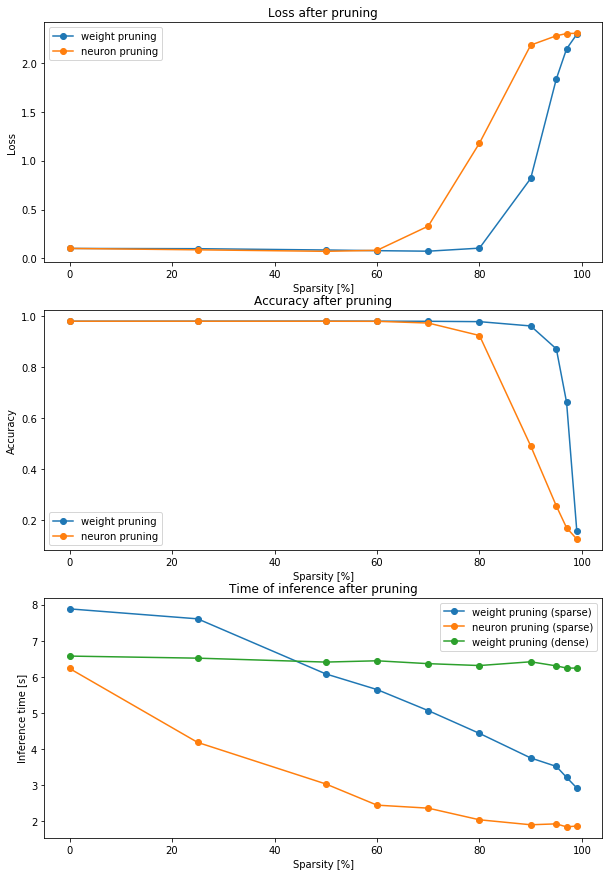

In [17]:
fig, ax = plt.subplots(3, figsize=(10,15))

ax[0].plot(metrics['pruning_percentage'], metrics['weight_dense_loss'], 'o-', label='weight pruning')
ax[0].plot(metrics['pruning_percentage'], metrics['neuron_dense_loss'], 'o-', label='neuron pruning')
ax[0].set_title('Loss after pruning')
ax[0].set_xlabel('Sparsity [%]')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(metrics['pruning_percentage'], metrics['weight_dense_acc'], 'o-', label='weight pruning')
ax[1].plot(metrics['pruning_percentage'], metrics['neuron_dense_acc'], 'o-', label='neuron pruning')
ax[1].set_title('Accuracy after pruning')
ax[1].set_xlabel('Sparsity [%]')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

ax[2].plot(metrics['pruning_percentage'], metrics['weight_sparse_dt'], 'o-', label='weight pruning (sparse)')
ax[2].plot(metrics['pruning_percentage'], metrics['neuron_sparse_dt'], 'o-', label='neuron pruning (sparse)')
ax[2].plot(metrics['pruning_percentage'], metrics['weight_dense_dt'], 'o-', label='weight pruning (dense)')
ax[2].set_title('Time of inference after pruning')
ax[2].set_xlabel('Sparsity [%]')
ax[2].set_ylabel('Inference time [s]')
ax[2].legend()

plt.show()

### Conclusions
#### 1. Loss and accuracy
We can see that after weight pruning we can't really see any reduction of the accuracy up until 90%. For neuron pruning it is 70-80%. First of all we can think about why is weight pruning more effective (meaning we can prune more of the network without losing the accuracy) than neuron pruning.

The answer might lay in the distribution of the weights inside each layer. Let's compare distribution of weights modulus and distribution of neurons norms.

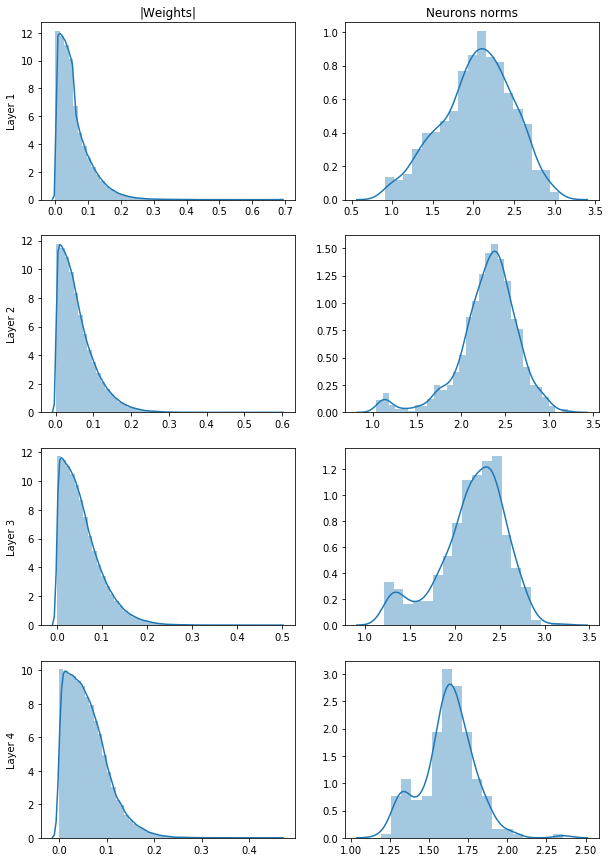

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(10,15))

ax[0][0].set(title="|Weights|")
ax[0][1].set(title="Neurons norms")
for ind in range(4):
    sns.distplot(np.fabs(dense_model.layers[ind + 1].get_weights()[0].reshape(-1)), ax=ax[ind][0], label='asdf')
    sns.distplot(np.linalg.norm(dense_model.layers[ind + 1].get_weights()[0], axis=0), ax=ax[ind][1])
    ax[ind][0].set(ylabel=f"Layer {ind+1}")

We can see that while we have plenty of small weights to prune, the distributiotn of neurons norms is more even out and as we remove more and more of them we remove also these precious big weights that have the biggest impact on the output. We can compare that to a situation in football. If you would remove 90% of worst players in Premier League all the superstars would remain. But if you were to remove 90% of worst teams, then majority of those superstars would be removed with their teams. Let's how the 10% of the biggest weights (our superstars) are distributed between the neurons.

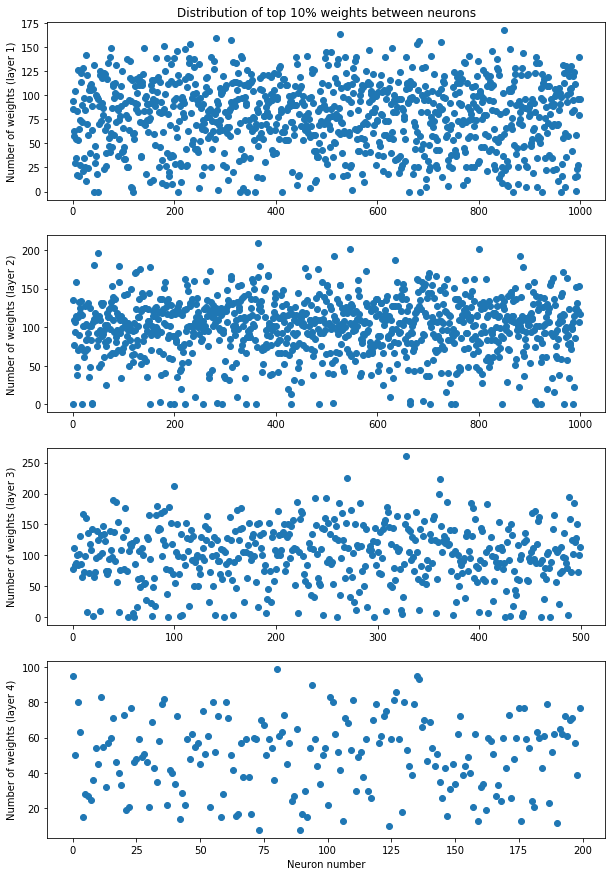

In [19]:
fig, ax = plt.subplots(4, 1, figsize=(10,15))

ax[0].set_title("Distribution of top 10% weights between neurons")
ax[3].set_xlabel("Neuron number")
for ind in range(4):
    weights = dense_model.layers[ind + 1].get_weights()[0]
    thrs = np.percentile(weights, 90)
    num_weights = (weights > thrs).sum(axis=0)
    ax[ind].plot(list(range(weights.shape[1])), num_weights, 'o')
    ax[ind].set_ylabel(f"Number of weights (layer {ind + 1})")

plt.show()

We can see that in fact the top weights are distributed quite evenly between neurons.

But there is also another reason why we can remove smaller part of the network with neuron pruning. When we remove single weight we don't affect the rest of the network that much, but when we remove the neuron, we not only remove weights of this neuron, but also all the weights in the next layer that were connected to this neuron. **So we actually remove larger part of the weights of whole network (not just one layer) while neuron pruning than in the weight pruning.**

The more difficult question is: how are we able to remove 90% of the network and almost don't loose any accuracy? The fist question to ask would be if we actually need all the weights during training or not, maybe we could just train from scratch the architecture we got after the pruning and get the same results. Let's take the neuron pruning. The architecture after n% pruning is simply the network with (100-n)% of the neurons in each layer. We can try, train in from scratch, and see if we actually get good accuracy.

In [20]:
small_metrics = defaultdict(list)
for perc in tqdm(PRUNING_PERCENTAGES):
    small_model = get_dense_model(dataset['shape'], hidden_sizes=(np.array([1000, 1000, 500, 200]) * ((100 - perc) / 100)).astype(np.int))
    small_model.fit(
        dataset['train'],
        epochs=NUM_EPOCHS,
        verbose=False
    )
    loss, acc = small_model.evaluate(dataset['test'], verbose=False)
    update_metrics(small_metrics, perc=perc, loss=loss, accuracy=acc)

100%|██████████| 10/10 [06:47<00:00, 25.45s/it]


Let's compare the results with results of the neuron pruning.

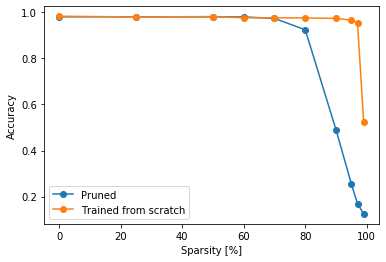

In [21]:
plt.plot(metrics['pruning_percentage'], metrics['neuron_dense_acc'], 'o-', label='Pruned')
plt.plot(metrics['pruning_percentage'], small_metrics['accuracy'], 'o-', label='Trained from scratch')
plt.xlabel('Sparsity [%]')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that actually that while training from scratch we could remove even more neurons so maybe our network was too large from the beginning. So this experiment can't confirm or reject this hypothesis. But in recent papers that investigate that problem we can also find this idea:
- [The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks (Frankle, Carbin)](https://arxiv.org/pdf/1803.03635.pdf),
- [Pruning neural networks: is it time to nip it in the bud? (Crowley et al.)](https://openreview.net/pdf?id=r1lbgwFj5m).

They show that we can retrive the architectures of pruned networks and train them from scratch with a good results. But it's still not clear how can we get those architectures without training the larger network first and give us the chance to find some "lottery ticket winners" inside our network.

#### 2. Inference time
We can observe that we can make use of our pruning and get the network to work way faster. The speed-up is linear with the pruning percentage. We can also see that our implementation of sparse model for neuron pruning is the faster one of two. That's possibly because of two factors:
- weight sparse model use `SparseTensor` which probably works slower than normal `Tensor` with the same size as non zero elements of a sparse tensor,
- in neuron sparse model we took into account the fact that removing neurons also removes connections from the next layer, which we mentioned before.

### Next steps
Next steps would be to do more thorough testing of the hypothesis with different architectures that can't be easly reduced like the one we used. More complex pruning methods should also be taken into consideration.